In [1]:
# We import the modules needed.
import sys, os, datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import tensorflow as tf
import tensorflow.contrib.slim as slim
import utils.utils as utils
from IPython.display import clear_output

In [2]:
def lrelu(X, leak=0.2):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * X + f2 * tf.abs(X)

In [3]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [4]:
mnisttrain = utils.load_mnist("data/","train")
mnisttest = utils.load_mnist("data/","t10k")
train_data = mnisttrain[0]
train_label = mnisttrain[1]
test_data = mnisttest[0]
test_label = mnisttest[1]
np.unique(train_label)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)
# Reshape to image for visualization
train_data = mnist.train.images
train_label = mnist.train.labels
test_data = mnist.test.images
test_label = mnist.test.labels

In [5]:
train_dataSet = utils.DataSet(train_data, train_label)
test_dataSet = utils.DataSet(test_data, test_label)

In [6]:
## Create model using wrappers
# the model is identical
def generator(x):
    with tf.variable_scope("generator"):
        x=tf.layers.dense(x, 512*7*7, activation=None)
        reshape = tf.reshape(x, [-1, 7, 7, 512]) # bwhc
        conv_1 = tf.layers.conv2d(reshape, 512, 3, padding = "same",activation = lrelu)
        conv_2_t = tf.depth_to_space(conv_1,2)
        conv_3 = tf.layers.conv2d(conv_2_t, 256, 3, padding = "same", activation = lrelu)
        conv_4_t = tf.depth_to_space(conv_3,2)
        conv_5 = tf.layers.conv2d(conv_4_t, 128, 5, padding = "same", activation = lrelu)
        out = tf.layers.conv2d(conv_5, 1, 5, padding = "same", activation = tf.nn.tanh)
        print(out)
    return out

In [7]:
# Create model using wrappers
# the model is identical
def discriminator(x, reuse = False):
    with tf.variable_scope("discriminator", reuse=reuse):
        # 1st conv-layer block
        x = tf.reshape(x, [-1, 28, 28, 1]) # bwhc
        conv_1 = tf.layers.conv2d(x, 16, 5, activation=lrelu)
        conv_1 = tf.layers.conv2d(conv_1, 32, 5, activation=lrelu)
        flat = slim.flatten(conv_1)
        D_logit = tf.layers.dense(flat, 1, activation=None)
        D_prob = tf.nn.sigmoid(D_logit)
    return D_prob, D_logit

In [8]:
# Parameters for the neural net
# step size for gradient decsent
learning_rate = 0.0001
#Iterations of forward and back pass
training_iters = 2**24

#size of each batch used for forward/backwards pass
batch_size = 128
display_step = 256
mb_size = 128
Z_dim = 100

tf.reset_default_graph()
# tf Graph input
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, [None, 28 * 28])
    y = tf.placeholder(tf.int64, None)
    keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)
    Z = tf.placeholder(tf.float32, shape=[None, 100], name='Z')

In [9]:
# Define loss and optimizer

G_sample = generator(Z)
D_real, D_logit_real = discriminator(x)
D_fake, D_logit_fake = discriminator(G_sample, reuse = True)

Tensor("generator/conv2d_4/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


In [10]:
with tf.name_scope('loss'):
    #find mean loss of batch
    #D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
    #G_loss = -tf.reduce_mean(tf.log(D_fake))
    # Alternative loss functions
    D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
    #D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
    #D_loss = D_loss_real + D_loss_fake
    #G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

with tf.name_scope('optimizer'):
    theta_G = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"generator")
    theta_D = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"discriminator")
    # Update D(X)'s parameters
    D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)

    # Update G(Z)'s parameters
    G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

# Add scalars to Tensorboard
tf.summary.scalar("Disc_Loss", D_loss)
tf.summary.scalar("Gen_Loss", G_loss)
merged_summaries = tf.summary.merge_all()

# Initializing the variables
init = tf.global_variables_initializer()

In [11]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

In [12]:
# Name for tensorboard.
name = 'tb_'+ str(datetime.datetime.now().strftime('%Y-%m-%d_%H%M_%S'))
cwd = os.getcwd()
tb_path = os.path.join(cwd, "Tensorboard")
tb_path = os.path.join(tb_path, name)

Currently: 0.1953125%
(16, 28, 28, 1)
(16, 28, 28, 1)


C:\Users\Jonathan Becktor\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\colors.py:823: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
C:\Users\Jonathan Becktor\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\ma\core.py:2766: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


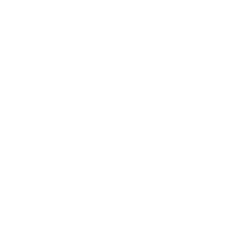

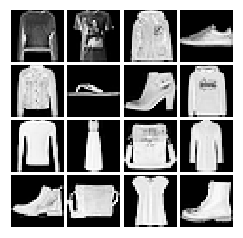

In [13]:
# Launch the graph
sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(tb_path, sess.graph)
disc_output = [D_solver, D_loss, merged_summaries]
gen_output = [G_solver, G_loss]
try:
    step = 1
    # Keep training until max iterations is reached
    while step * batch_size < training_iters:
        # load first batch
        X_mb, _ = train_dataSet.next_batch(mb_size)
        feed_dict_disc = {x: X_mb, Z: sample_Z(mb_size, Z_dim)}
        feed_dict_gen = {Z: sample_Z(mb_size, Z_dim)}
        _, D_loss_curr,summary = sess.run(disc_output, feed_dict=feed_dict_disc)
        _, G_loss_curr = sess.run(gen_output, feed_dict=feed_dict_gen)

        # Testing step see if data is converging
        if step % display_step == 0:
            clear_output()
            prec = ((step * batch_size)/training_iters)*100
            print("Currently: "+ str(prec)+"%")
            samples = sess.run(G_sample, feed_dict={Z: sample_Z(16, Z_dim)})
            print(samples.shape)
            fig = plot(samples)
            print(samples.shape)
            #plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')

            plt.show()
            plt.close(fig)
            fig2 = plot(X_mb[:16])
            plt.show()
            plt.close(fig2)
            writer.add_summary(summary, step)
        step += 1

    print("\nOptimization Finished!, Training Accuracy= {:.3f}".format(acc))

except KeyboardInterrupt:
    pass

In [14]:
# Inference
# Test on the test dataset to see how good our network is]
# append accuracies from each batch
acc_app=[]
for i in range(10):
    batch_x, batch_y = test_dataSet.next_batch(1056)
    feed_dict={x: batch_x, y: batch_y, keep_prob: 1.}
    # Forward pass and return accuracy and predictions
    acc, cp = sess.run([accuracy, predictions], feed_dict)
    acc_app.append(acc)
mean = np.mean(np.array(acc_app))
print("Accuracy for the testing dataset is: {0:.4f}".format(mean))

NameError: name 'accuracy' is not defined

In [ ]:
# select a random sample in the test data
rnd = np.random.randint(len(test_dataSet.data)-1)
image = test_dataSet.data[rnd]
label = test_dataSet.label[rnd]
show = np.reshape(image,(28,28))
plt.imshow(show, cmap='gray')
plt.show()

In [ ]:
# expand dimensions of image to have get right dimensions
# basically saying the input has a batch size of 1
exp_img = np.expand_dims(image, 0)
feed_dict={x: exp_img, y: label, keep_prob: 1.}
acc, pred = sess.run([accuracy, predictions], feed_dict)

print("Prediction: {0} \nLabel: {1} \nis equal? {2}".format(pred[0], label, pred[0] == label))